# Titaninc Solutions

This notebook is here to propose solution to the titanic machine learning problem.
The workflow followed to do so is as follow :

1. Business Comprehension
2. Data acquisition
3. Data wrangling (cleaning)
3. Data analysis
4. Model training and prediction
5. Submission

## Business comprehension

On April 15, 1912 the titanic sank after colliding with an iceberg. The titanic's crew was composed of different categories : women, men, upper class, lower class. These different categories may have not the same luck to survive. The goal is to find model that can predict if a member is going to survic or not.

## Data acquisition 

In [1]:
import pandas as pd

DATA_DIR = './data/'

train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')

train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

The sets are composed of 10 features. The train set is made of 891 samples and the test set of 418 samples. We can already discern between different types of features :

Categorical nominal features are sex and embarked
Categorical ordinal features are pclass.
Numerical ratio features are age (continuous), sibsp (discrete), parch (discrete), fare (continuous).
Numerical interval features are ticket and cabin. They are both discrete features.

## Data wrangling.

Data wrangling include data architecture to best store and process data, data governance, data extraction and data cleaning. For this problem we are only interested in data cleaning that is correcting, completing, creating and converting.

### Correcting 

Correcting the data implies to review the data for non abberant values like outliers. For this let's check the different values we have for our different features. We may also want to drop some features as they are not interesting to detect survival. 

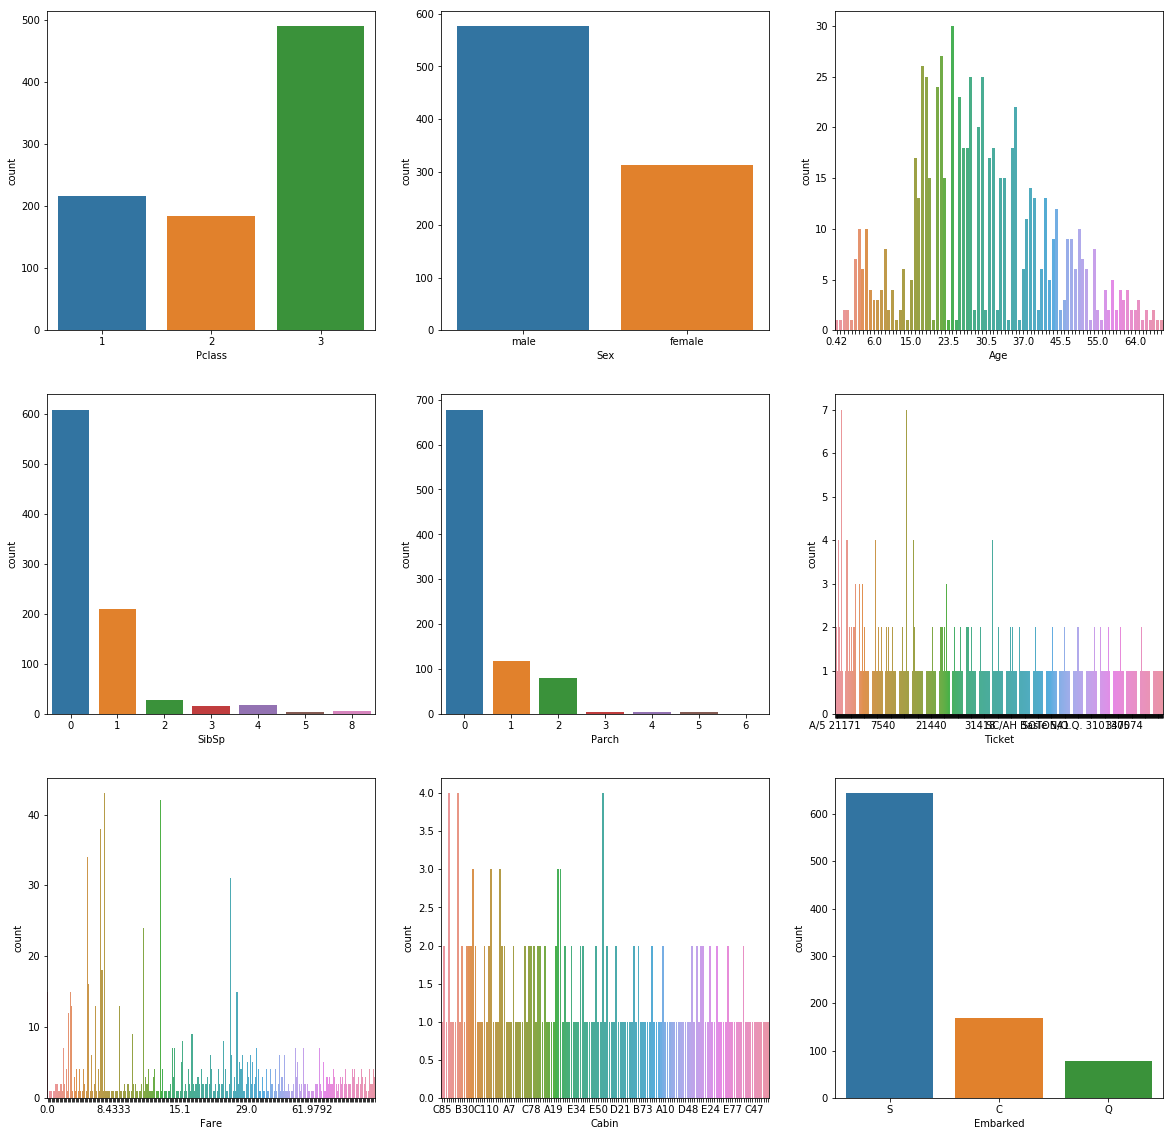

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decrease the density of x labels
def decrease_density(ax, rate):
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % rate == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

# Set the grid plot
f, ax_arr  = plt.subplots(3, 3, figsize=(20, 20))

# Build the barplot
sns.factorplot(x="Pclass", data=train_df, kind="count", ax=ax_arr[0][0])
sns.factorplot(x="Sex", data=train_df, kind="count", ax=ax_arr[0][1])
g = sns.factorplot(x="Age", data=train_df, kind="count", ax=ax_arr[0][2])
decrease_density(ax_arr[0][2], 10)
sns.factorplot(x="SibSp", data=train_df, kind="count", ax=ax_arr[1][0])
sns.factorplot(x="Parch", data=train_df, kind="count", ax=ax_arr[1][1])
sns.factorplot(x="Ticket", data=train_df, kind="count", ax=ax_arr[1][2])
decrease_density(ax_arr[1][2], 100)
sns.factorplot(x="Fare", data=train_df, kind="count", ax=ax_arr[2][0])
decrease_density(ax_arr[2][0], 50)
sns.factorplot(x="Cabin", data=train_df, kind="count", ax=ax_arr[2][1])
decrease_density(ax_arr[2][1], 10)
sns.factorplot(x="Embarked", data=train_df, kind="count", ax=ax_arr[2][2])

# Delete the seaborn plots
for i in range(2,11):
    plt.close(i)

The different values for our variables seems to be OK. Categorical variables such as Pclass, Sex, SibSp, Parch and Embarked display coherent values. Age is ranging from 0 to a little more than 64 which is coherent. Ticket number for the most part is unique for each member which we can assume is logic since each member has a unique ticket. Strangely some passenger seems to share the same ticket. Fare is ranging from 0 to a little more than 62 which is fine. Finally we can see that the cabin only host 1 to 4 passengers which seems again allright. Names and PassengerId are not shown here as they are obviously unique. 

Among the features PassengerId, Name, Ticket and Cabin may be dropped as they provide no insight to detect survival. 

In [4]:
# Drop non relevant features
new_train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
new_test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

### Completing

Completing requires to check for null or missing values. This is bad because some algorithms does not know how to handle missing values. There are two possibilities to handle null or missing values. The samples can be simply dropped but it is probably not a good choice expecially if the samples with missing values represent a large part of the population. The other method is to populate missing values with a value of our choice. For categorical variable the value used is often the mode that is the most frequent value. For numerical variables we can use one of the different measures which are the mean, the median or the mean + randomized standard deviation. 

So first let's check if our features contain null or missing values.

In [5]:
print(new_train_df.isnull().sum())
print('_'*40)
new_test_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
________________________________________


Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In the training dataset The Age and Embarked features contains NaN values and the Fare features in the test set also contains NaN values. For the Age and Fare features we will use the median to impute values and we will use the mode for Embarked features. 

In [6]:
# Fill the missing values with median or mode
new_train_df['Age'].fillna(new_train_df['Age'].median(), inplace = True)
new_test_df['Age'].fillna(new_test_df['Age'].median(), inplace = True)
new_train_df['Embarked'].fillna(new_train_df['Embarked'].mode()[0], inplace = True)
new_test_df['Fare'].fillna(new_test_df['Fare'].median(), inplace = True)

### Creating

Feature enginering consist to use existing features to create new features which may be relevant for the analysis. For this dataset we will create a Title feature from the Name features as well as a Family features which will count the number of member in the family. Family features will be constructed from the SibSp and Parch features. 

In [7]:
# Build the Family features
new_train_df['Family'] = new_train_df ['SibSp'] + new_train_df['Parch'] + 1
new_test_df['Family'] = new_test_df['SibSp'] + new_test_df['Parch'] + 1
new_train_df = new_train_df.drop(['SibSp', 'Parch'], axis=1)
new_test_df = new_test_df.drop(['SibSp', 'Parch'], axis=1)

# Build the Title features
new_train_df['Title'] = train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
new_test_df['Title'] = test_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

### Converting

Converting may be needed for categorical variable to transform them into dummy variables. Also we can convert Age and Fare continuous variables to categorical variables by creating bands.

In [8]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical variables Sex, Embarked and Title into dummy variables
label = LabelEncoder()
new_train_df['Sex'] = label.fit_transform(new_train_df['Sex'])
new_test_df['Sex'] = label.fit_transform(new_test_df['Sex'])
new_train_df['Embarked'] = label.fit_transform(new_train_df['Embarked'])
new_test_df['Embarked'] = label.fit_transform(new_test_df['Embarked'])
new_train_df['Title'] = label.fit_transform(new_train_df['Title'])
new_test_df['Title'] = label.fit_transform(new_test_df['Title'])

# Convert continuous variables Age and Fare to categorical variables
new_train_df['Age'] = pd.cut(new_train_df['Age'], 10)
new_test_df['Age'] = pd.cut(new_test_df['Age'], 10)
new_train_df['Fare'] = pd.cut(new_train_df['Fare'], 10)
new_test_df['Fare'] = pd.cut(new_test_df['Fare'], 10)

new_train_df['Age'] = label.fit_transform(new_train_df['Age'])
new_test_df['Age'] = label.fit_transform(new_test_df['Age'])
new_train_df['Fare'] = label.fit_transform(new_train_df['Fare'])
new_test_df['Fare'] = label.fit_transform(new_test_df['Fare'])

## Data analysis

First we would like to check for correlation between our features and the survival state. From the definition problem women, child and upper class are most likely to survive. For age we can create age band  We can verify that.

In [9]:
new_train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
new_train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,0,0.742038
1,1,0.188908


In [11]:
new_train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,0,0.742038
1,1,0.188908


We can see that effectively upper class, women and child (<6) are most likely to survive. Indeed first class has a rate of 63% of surviving, women has a rate of 74% and child (class 0) have a high rate.

We can also check the correlation for the other variables.

In [12]:
new_train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean()

,Fare,Survived
0,0,0.318306
1,1,0.660377
2,2,0.741935
3,3,1.000000
4,4,0.636364
5,5,0.666667
6,6,1.000000


In [13]:
new_train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,0,0.553571
1,1,0.389610
2,2,0.339009


In [14]:
new_train_df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [15]:
new_train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,0,0.000000
1,1,0.500000
2,2,0.000000
3,3,0.428571
4,4,0.000000
5,5,1.000000
6,6,0.500000
7,7,0.575000
8,8,0.697802
9,9,1.000000


We can see that high fare have better luck to survive that low fare and also that some title are sure to survive

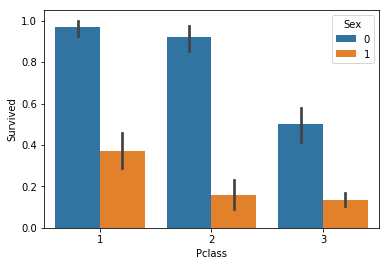

In [16]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=new_train_df)

Again we can see that female (0) are more likely to survive than male whatever the class. 

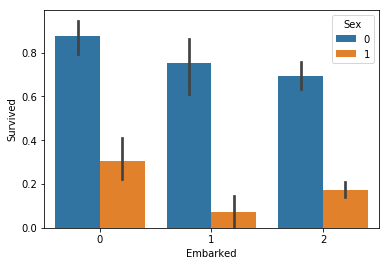

In [17]:
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=new_train_df)

Once more female are more likely to survive than male whatever the port of embarkation.

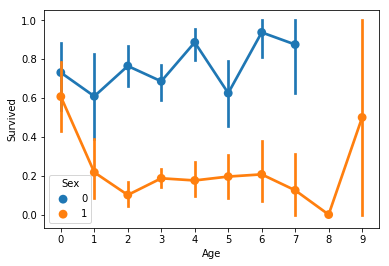

In [18]:
sns.pointplot(x='Age', y='Survived', hue='Sex', data=new_train_df)

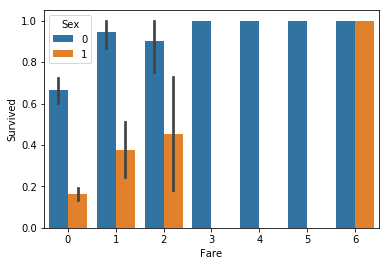

In [19]:
sns.barplot(x='Fare', y='Survived', hue='Sex', data=new_train_df)

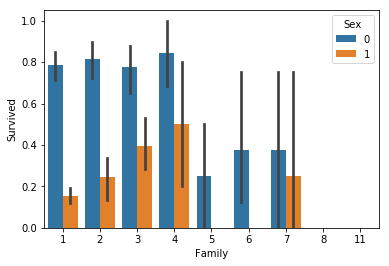

In [20]:
sns.barplot(x='Family', y='Survived', hue='Sex', data=new_train_df)

Whatever the features used we can see that female are more likely to survive than male.

## Model training and prediction

We want to predict a binary variables (0 or 1) so our problem is a classification problem. We chose from a number of different algorith that fit that requirement.

In [80]:
# Inport machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

def normalize_features(X):
    """
    Normalize the features by substracting the mean and
    dividing by the standard deviation

    :param X: the features
    :return:
    """

    for features in X:
        feats = X[features].tolist()
        mean = np.mean(feats)
        std = np.std(feats)
        feats = (feats - mean)/std
        X[features] = feats

    return X


# Create the training features set and labels set as well as the test features set
X_train = new_train_df.drop("Survived", axis=1)
Y_train = new_train_df["Survived"]
X_val  = new_test_df

X_train = normalize_features(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

In [22]:
# Logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)

acc_log = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_log

80.68

We can use the coefficients of the logistic regression to verify that our engineered features are good artificial features

In [23]:
coeff_df = pd.DataFrame(new_train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,Fare,0.260251
6,Title,0.065833
5,Family,-0.153430
2,Age,-0.173645
4,Embarked,-0.289029
0,Pclass,-0.669213
1,Sex,-2.388703


We can see that Pclass and Sex have high negative coefficient meaning that when the Pclass or the Sex increase the probability of survival deacrease a lot. Sadly our Family and Title feature does not seem to have a high correlation with the probaility of survival. 

In [24]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_svc

81.69

In [25]:
# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_knn

79.66

In [26]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_gaussian

80.0

In [27]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_perceptron

c:\users\vette\desktop\projets\titanic-machine-learning-from-disaster\titanic\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


80.68

In [28]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_sgd

c:\users\vette\desktop\projets\titanic-machine-learning-from-disaster\titanic\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


59.66

In [29]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_decision_tree

80.0

In [30]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_random_forest

81.02

The best scoring algorithms is Support Vector Machine. Now I would like to tune this model to find the most performant parameters. For this I will use grid search.

In [47]:
from sklearn.metrics import make_scorer, accuracy_score 
from sklearn.model_selection import GridSearchCV

svc = SVC()

# Choose some parameter combinations to try
parameters = {
    'C': [0.3, 0.7, 1.0, 1.3, 1.7, 2],
    'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
    'degree': [1, 2, 3, 4, 5],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(svc, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
Y_pred = clf.predict(X_test)
acc_svc = round(accuracy_score(y_test, Y_pred) * 100, 2)
acc_svc

82.37

The accuracy score has as expected increased but we can still verify the effectiveness of the algorithm using KFold

In [75]:
from sklearn.cross_validation import KFold
import numpy as np

X_train_values = new_train_df.drop("Survived", axis=1).values
Y_train_values = new_train_df["Survived"].values

kf = KFold(X_train.shape[0], n_folds=10)
outcomes = []
fold = 0

for train_index, test_index in kf:
    fold += 1
    X_train, X_test = X_train_values[train_index], X_train_values[test_index]
    y_train, y_test = Y_train_values[train_index], Y_train_values[test_index]
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    outcomes.append(accuracy)
    print("Fold {0} accuracy: {1}".format(fold, accuracy))     
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome))

Fold 1 accuracy: 0.7846153846153846
Fold 2 accuracy: 0.8153846153846154
Fold 3 accuracy: 0.9076923076923077
Fold 4 accuracy: 0.7384615384615385
Fold 5 accuracy: 0.7846153846153846
Fold 6 accuracy: 0.9384615384615385
Fold 7 accuracy: 0.7384615384615385
Fold 8 accuracy: 0.8
Fold 9 accuracy: 0.8153846153846154
Fold 10 accuracy: 0.8125
Mean Accuracy: 0.8135576923076921


## Submission

In [78]:
X_val = normalize_features(X_val)

final_pred = clf.predict(X_val)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": final_pred
    })

submission.to_csv('./submission.csv', index=False)